In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import requests
import folium
from math import radians, sin, cos, sqrt, atan2
from datetime import datetime, timedelta
import numpy as np
from folium.plugins import HeatMap
from scipy.spatial.distance import pdist, squareform
from folium.plugins import MarkerCluster
from IPython.display import display
import glob
import os
import geopandas as gpd
import contextily as ctx
import zipfile
from shapely.geometry import Point
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.stattools import durbin_watson
import matplotlib.dates as mdates



In [2]:
df = pd.read_csv('Hourly outflow with census tract.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000848 entries, 0 to 7000847
Data columns (total 28 columns):
 #   Column             Dtype  
---  ------             -----  
 0   DateTime           object 
 1   Date               object 
 2   Year               int64  
 3   Month              object 
 4   Month_Num          int64  
 5   Day_of_Week        object 
 6   Day_of_Week_Num    int64  
 7   Hour               int64  
 8   Is_Weekend         int64  
 9   Time_Period        object 
 10  Station_Name       object 
 11  User Type          object 
 12  Model              object 
 13  Outflow_Count      float64
 14  MA_3H              float64
 15  MA_24H             float64
 16  MA_Week            float64
 17  Latitude           float64
 18  Longitude          float64
 19  Temperature        float64
 20  Dew Point          float64
 21  Relative Humidity  float64
 22  Precipitation      float64
 23  Wind Direction     float64
 24  Wind Speed         float64
 25  Pressure          

In [4]:
df.head(10)

,DateTime,Date,Year,Month,Month_Num,Day_of_Week,Day_of_Week_Num,Hour,Is_Weekend,Time_Period,...,Longitude,Temperature,Dew Point,Relative Humidity,Precipitation,Wind Direction,Wind Speed,Pressure,Cloud Cover,Census_Tract
0,2023-05-01 00:00:00,2023-05-01,2023,May,5,Monday,0,0,0,Late_Night,...,-79.370666,9.8,7.0,83.0,0.2,300.0,22.3,993.4,7.0,5350013.01
1,2023-05-01 01:00:00,2023-05-01,2023,May,5,Monday,0,1,0,Late_Night,...,-79.370666,9.0,6.1,82.0,0.2,300.0,24.1,993.4,7.0,5350013.01
2,2023-05-01 02:00:00,2023-05-01,2023,May,5,Monday,0,2,0,Late_Night,...,-79.370666,9.0,6.1,82.0,0.2,280.0,14.8,993.2,7.0,5350013.01
3,2023-05-01 03:00:00,2023-05-01,2023,May,5,Monday,0,3,0,Late_Night,...,-79.370666,8.7,5.4,80.0,0.0,290.0,13.0,992.3,3.0,5350013.01
4,2023-05-01 04:00:00,2023-05-01,2023,May,5,Monday,0,4,0,Late_Night,...,-79.370666,7.0,5.9,93.0,0.0,260.0,14.8,991.8,3.0,5350013.01
5,2023-05-01 05:00:00,2023-05-01,2023,May,5,Monday,0,5,0,Late_Night,...,-79.370666,8.0,4.9,81.0,0.0,310.0,22.3,990.9,3.0,5350013.01
6,2023-05-01 06:00:00,2023-05-01,2023,May,5,Monday,0,6,0,Morning,...,-79.370666,7.7,4.5,80.0,0.0,290.0,16.6,989.7,3.0,5350013.01
7,2023-05-01 07:00:00,2023-05-01,2023,May,5,Monday,0,7,0,Morning,...,-79.370666,8.0,4.0,76.0,0.0,300.0,20.5,988.6,3.0,5350013.01
8,2023-05-01 08:00:00,2023-05-01,2023,May,5,Monday,0,8,0,Morning,...,-79.370666,7.0,4.0,81.0,0.0,260.0,7.6,988.5,3.0,5350013.01
9,2023-05-01 09:00:00,2023-05-01,2023,May,5,Monday,0,9,0,Morning,...,-79.370666,6.3,4.5,88.0,0.0,250.0,3.6,988.3,3.0,5350013.01


In [4]:
def analyze_categorical_columns(df):
    """
    Analyze categorical columns in a DataFrame and display their unique values
    and counts.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    
    Returns:
    dict: Dictionary containing analysis results for each categorical column
    """
    # Select object and category dtype columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    analysis_results = {}
    
    for col in categorical_cols:
        # Get unique values and their counts
        value_counts = df[col].value_counts()
        
        # Calculate percentages
        value_percentages = df[col].value_counts(normalize=True) * 100
        
        # Combine counts and percentages
        analysis = pd.DataFrame({
            'Count': value_counts,
            'Percentage': value_percentages.round(2)
        })
        
        # Add number of unique values and missing values
        missing_count = df[col].isnull().sum()
        
        analysis_results[col] = {
            'unique_values': analysis,
            'total_unique': len(value_counts),
            'missing_values': missing_count,
            'missing_percentage': (missing_count / len(df) * 100).round(2)
        }
    
    return analysis_results


# Get analysis
results = analyze_categorical_columns(df)

# Print results for each column
for col, analysis in results.items():
    print(f"\nColumn: {col}")
    print(f"Total unique values: {analysis['total_unique']}")
    print(f"Missing values: {analysis['missing_values']} ({analysis['missing_percentage']}%)")
    print("\nValue distribution:")
    print(analysis['unique_values'])



Column: DateTime
Total unique values: 8784
Missing values: 0 (0.0%)

Value distribution:
                     Count  Percentage
DateTime                              
2023-05-01 00:00:00    797        0.01
2023-12-31 03:00:00    797        0.01
2023-12-30 21:00:00    797        0.01
2023-12-30 22:00:00    797        0.01
2023-12-30 23:00:00    797        0.01
...                    ...         ...
2023-08-30 17:00:00    797        0.01
2023-08-30 16:00:00    797        0.01
2023-08-30 15:00:00    797        0.01
2023-08-30 14:00:00    797        0.01
2024-04-30 23:00:00    797        0.01

[8784 rows x 2 columns]

Column: Date
Total unique values: 366
Missing values: 0 (0.0%)

Value distribution:
            Count  Percentage
Date                         
2023-05-01  19128        0.27
2024-01-07  19128        0.27
2024-01-05  19128        0.27
2024-01-04  19128        0.27
2024-01-03  19128        0.27
...           ...         ...
2023-08-29  19128        0.27
2023-08-28  19128      

# Toronto Bikeshare System Exploratory Data Analysis
## Comprehensive Analysis of Usage Patterns and Influencing Factors

This notebook performs an in-depth exploratory data analysis of Toronto's bikeshare system, focusing on station outflows and various influencing factors.

### Dataset Overview

The processed dataset contains 7,000,848 hourly records with 28 columns, including:
- Temporal features (DateTime, Date, Year, Month, Hour, etc.)
- Station information (Name, Latitude, Longitude, Census Tract)
- Usage metrics (Outflow Count, Moving Averages)
- Weather conditions (Temperature, Precipitation, Wind, etc.)


### Exploratory Data Analysis Components

The `perform_eda()` function conducts a comprehensive analysis across five main areas:

#### 1. Overall System Usage Analysis
- Total system outflows
- Average daily trips
- Distribution by user type
- Distribution by bike model
- Temporal trends visualization with moving averages:
  - 3-hour MA (short-term patterns)
  - 24-hour MA (daily patterns)
  - Weekly MA (long-term trends)

#### 2. Station and Census Tract Analysis
- Top 15 busiest stations with their census tracts
- Top 10 busiest census tracts
- Station usage distribution visualization
- Box plots of hourly outflows for top stations

#### 3. Temporal Patterns Analysis
Visualizations and statistics for:
- Hourly patterns by user type
- Daily patterns (weekday vs weekend)
- Monthly trends
- Time period distribution (Morning, Midday, Evening, Night)

#### 4. Weather Impact Analysis
- Correlation analysis between weather variables and outflows
- Correlation matrix visualization
- Temperature impact by user type
- Precipitation effects
- Wind speed influence
- Weather variable relationships:
  - Temperature
  - Precipitation
  - Wind Speed
  - Cloud Cover
  - Dew Point
  - Relative Humidity
  - Pressure

#### 5. Census Tract Usage Patterns
- Average usage patterns by tract
- Temporal variations across different tracts
- Geographic distribution of demand
- Top 5 census tracts hourly patterns

### Visualization Details

All visualizations are created using:
- Seaborn with 'husl' color palette
- Matplotlib with 'seaborn-v0_8' style
- Standardized figure sizes for consistency
- Clear titles, labels, and legends
- Grid lines for better readability

### Key Findings and Statistics

The analysis reveals:
1. System Usage:
   - Total outflows and daily averages
   - User type distribution
   - Bike model preferences

2. Spatial Patterns:
   - High-demand stations and areas
   - Census tract usage patterns
   - Geographic clustering of demand

3. Temporal Trends:
   - Peak usage hours
   - Weekday vs weekend patterns
   - Seasonal variations

4. Weather Impacts:
   - Temperature correlations
   - Precipitation effects
   - Weather variable relationships

### Usage for Demand Forecasting

This EDA provides crucial insights for demand forecasting by:
1. Identifying key demand drivers
2. Understanding temporal patterns
3. Quantifying weather impacts
4. Recognizing spatial dependencies
5. Revealing user behavior patterns

The findings from this analysis can inform feature selection and model development for the demand forecasting system.


Overall System Usage Analysis
Total Outflows: 5,336,042
Average Daily Outflows: 14579.3

Outflows by User Type:
Annual Member: 243,772 trips (4.57%)
Casual Member: 5,092,270 trips (95.43%)

Outflows by Bike Model:
EFIT: 23,673 trips (0.44%)
EFIT G5: 49,034 trips (0.92%)
ICONIC: 833,828 trips (15.63%)
unknown: 4,429,507 trips (83.01%)

Value Ranges:
Outflow_Count:
  Min: 0.14
  Max: 1.32
  Mean: 0.76
MA_3H:
  Min: 0.14
  Max: 1.32
  Mean: 0.76
MA_24H:
  Min: 0.16
  Max: 1.27
  Mean: 0.76
MA_Week:
  Min: 0.21
  Max: 1.22
  Mean: 0.76


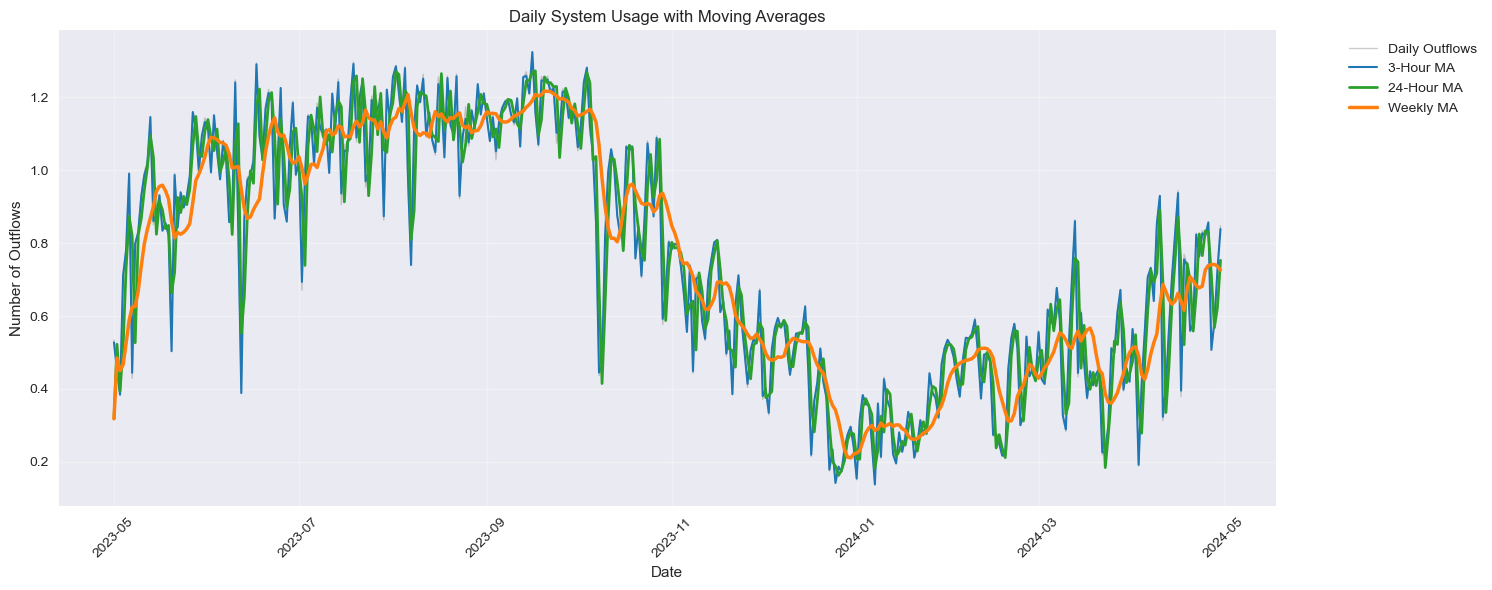


Station and Census Tract Analysis

Top 15 Busiest Stations:
Bay St / College St (East Side) (Census Tract: 5350035.0): 43,022 outflows
King St W / Brant St (Census Tract: 5350011.01): 42,493 outflows
Union Station (Census Tract: 5350013.01): 39,692 outflows
York St / Queens Quay W (Census Tract: 5350012.04): 39,284 outflows
Bay St / Wellesley St W (Census Tract: 5350062.03): 37,194 outflows
Queen St W / John St (Census Tract: 5350036.0): 33,759 outflows
Dundas St W / Yonge St (Census Tract: 5350035.0): 32,538 outflows
College Park - Yonge St Entrance (Census Tract: 5350035.0): 32,081 outflows
Richmond St E / Yonge St (Census Tract: 5350015.0): 31,650 outflows
Simcoe St / Queen St W (Census Tract: 5350014.0): 31,223 outflows
College St / Major St (Census Tract: 5350059.0): 29,829 outflows
St. George St / Bloor St W (Census Tract: 5350061.0): 29,331 outflows
Dundas St E / Regent Park Blvd (Census Tract: 5350030.0): 28,937 outflows
Spadina Ave / Harbord St - SMART (Census Tract: 5350061.

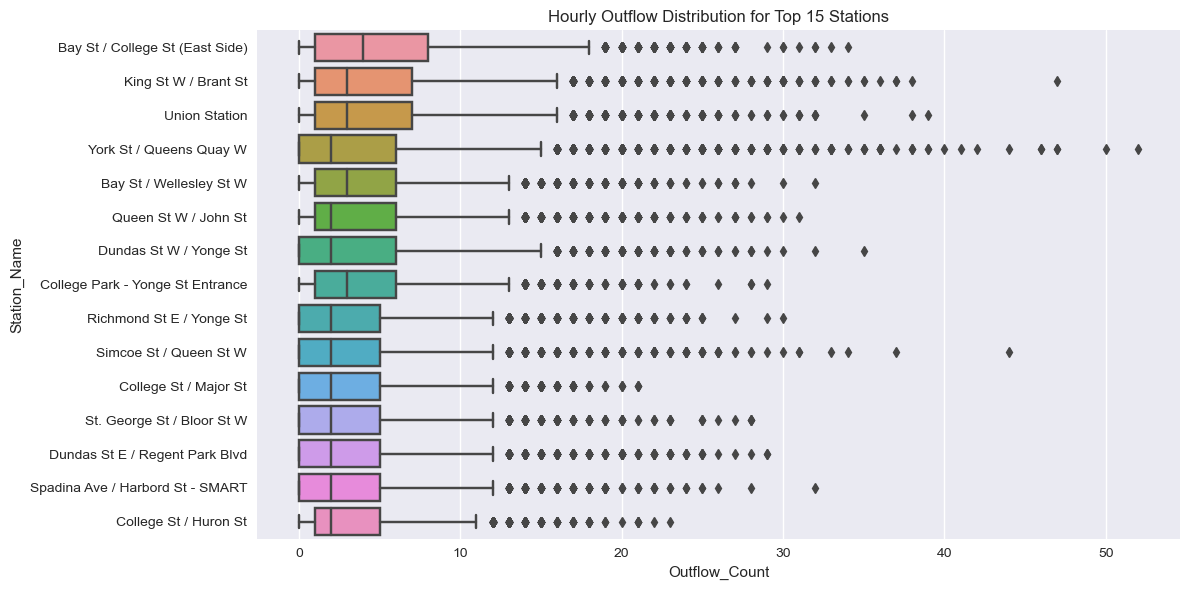


Temporal Patterns Analysis


<Figure size 1200x600 with 0 Axes>

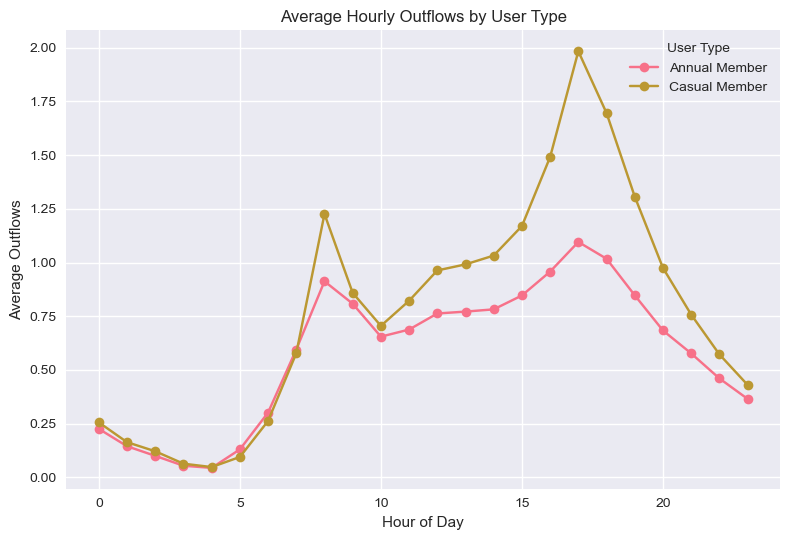

<Figure size 1200x600 with 0 Axes>

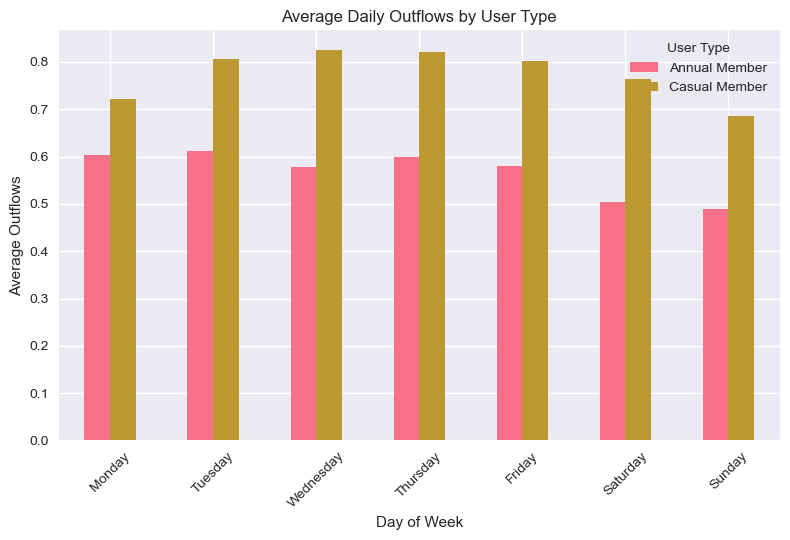


Weather Impact Analysis

Correlations with Outflows:
Outflow_Count        1.000000
Temperature          0.173880
Dew Point            0.147694
Pressure             0.013557
Precipitation       -0.019541
Cloud Cover         -0.028732
Wind Speed          -0.042877
Relative Humidity   -0.048171
Name: Outflow_Count, dtype: float64


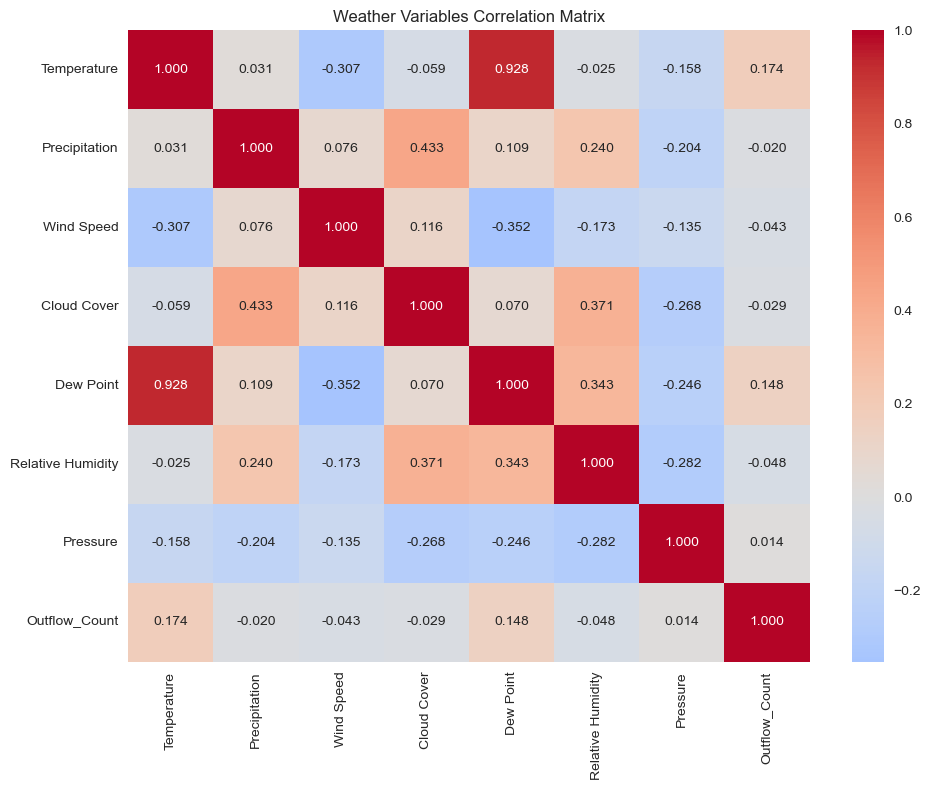

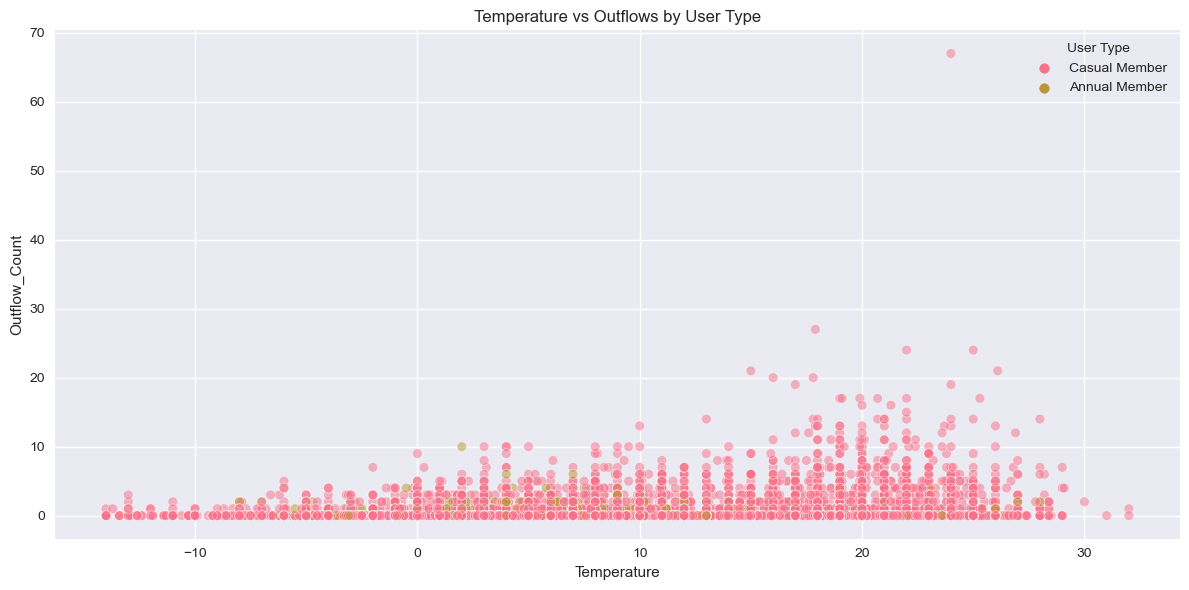


Census Tract Usage Patterns


<Figure size 1200x600 with 0 Axes>

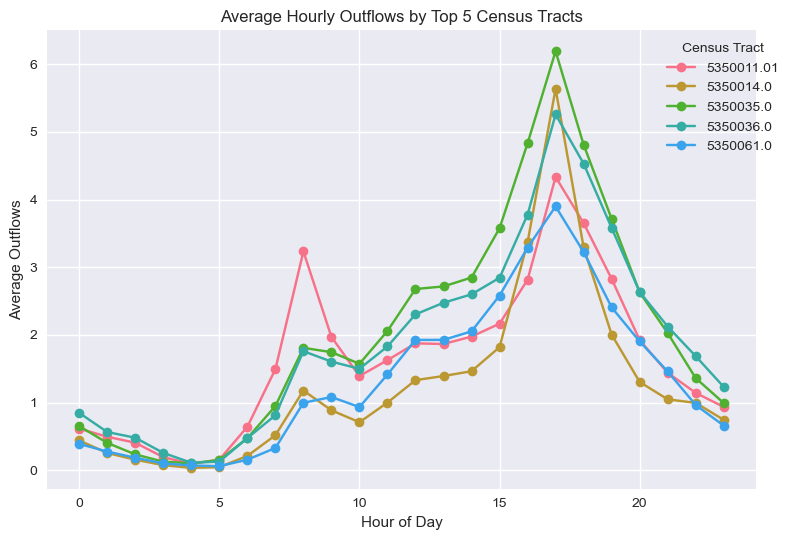

In [5]:
def perform_eda(df):
    """
    Performs comprehensive exploratory data analysis focusing on outflow patterns.
    """
    # Create a copy and convert DateTime
    df = df.copy()
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    
    # Set plotting style
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")
    
    def print_section(title):
        print("\n" + "="*50)
        print(title)
        print("="*50)
    
    # 1. Overall System Usage
    print_section("Overall System Usage Analysis")
    
    # Total trips and averages
    total_trips = df['Outflow_Count'].sum()
    avg_daily_trips = df.groupby(df['DateTime'].dt.date)['Outflow_Count'].sum().mean()
    print(f"Total Outflows: {total_trips:,.0f}")
    print(f"Average Daily Outflows: {avg_daily_trips:.1f}")
    
    # User Type Distribution
    print("\nOutflows by User Type:")
    user_dist = df.groupby('User Type')['Outflow_Count'].sum()
    user_dist_pct = (user_dist / user_dist.sum() * 100).round(2)
    for user_type, pct in user_dist_pct.items():
        print(f"{user_type}: {user_dist[user_type]:,.0f} trips ({pct}%)")
    
    # Bike Model Distribution
    print("\nOutflows by Bike Model:")
    model_dist = df.groupby('Model')['Outflow_Count'].sum()
    model_dist_pct = (model_dist / model_dist.sum() * 100).round(2)
    for model, pct in model_dist_pct.items():
        print(f"{model}: {model_dist[model]:,.0f} trips ({pct}%)")
    
    # Plot daily usage pattern
    # Convert DateTime to datetime type if not already
    df['DateTime'] = pd.to_datetime(df['DateTime'])

    # Create the plot
    plt.figure(figsize=(15, 6))

    # Calculate daily aggregates for outflows
    daily_data = df.groupby(df['DateTime'].dt.date).agg({
        'Outflow_Count': 'sum',
         'MA_3H': 'sum',        # Sum instead of mean to match the scale
         'MA_24H': 'sum',       # Sum instead of mean to match the scale
     'MA_Week': 'sum'       # Sum instead of mean to match the scale
     }).div(df.groupby(df['DateTime'].dt.date).size(), axis=0)  # Divide by number of records per day

    # Plot raw data and moving averages
    daily_data['Outflow_Count'].plot(color='gray', alpha=0.4, label='Daily Outflows', linewidth=1)
    daily_data['MA_3H'].plot(color='#1f77b4', label='3-Hour MA', linewidth=1.5)
    daily_data['MA_24H'].plot(color='#2ca02c', label='24-Hour MA', linewidth=2)
    daily_data['MA_Week'].plot(color='#ff7f0e', label='Weekly MA', linewidth=2.5)

    plt.title('Daily System Usage with Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Number of Outflows')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Print some statistics to verify the scales
    print("\nValue Ranges:")
    for col in daily_data.columns:
        print(f"{col}:")
        print(f"  Min: {daily_data[col].min():.2f}")
        print(f"  Max: {daily_data[col].max():.2f}")
        print(f"  Mean: {daily_data[col].mean():.2f}")

    plt.show() 

    # 2. Station and Census Tract Analysis
    print_section("Station and Census Tract Analysis")
    
    # Station statistics
    station_stats = df.groupby(['Station_Name', 'Census_Tract'])['Outflow_Count'].sum().sort_values(ascending=False)
    
    print("\nTop 15 Busiest Stations:")
    for station, outflows in station_stats.head(15).items():
        print(f"{station[0]} (Census Tract: {station[1]}): {outflows:,.0f} outflows")
    
    # Census tract statistics
    print("\nTop 10 Busiest Census Tracts:")
    tract_stats = df.groupby('Census_Tract')['Outflow_Count'].sum().sort_values(ascending=False)
    for tract, outflows in tract_stats.head(10).items():
        print(f"Census Tract {tract}: {outflows:,.0f} outflows")
    
    # Plot station usage distribution
    plt.figure(figsize=(12, 6))
    top_15_stations = station_stats.head(15).index.get_level_values('Station_Name')
    station_data = df[df['Station_Name'].isin(top_15_stations)]
    sns.boxplot(data=station_data, y='Station_Name', x='Outflow_Count',
                order=top_15_stations)
    plt.title('Hourly Outflow Distribution for Top 15 Stations')
    plt.tight_layout()
    plt.show()
    
    # 3. Temporal Patterns
    print_section("Temporal Patterns Analysis")
    
    # Hourly patterns by user type
    plt.figure(figsize=(12, 6))
    hourly_by_type = df.groupby(['Hour', 'User Type'])['Outflow_Count'].mean().unstack()
    hourly_by_type.plot(marker='o')
    plt.title('Average Hourly Outflows by User Type')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Outflows')
    plt.legend(title='User Type')
    plt.tight_layout()
    plt.show()
    
    # Daily patterns by user type
    plt.figure(figsize=(12, 6))
    df['Day_Name'] = df['DateTime'].dt.strftime('%A')
    daily_by_type = df.groupby(['Day_Name', 'User Type'])['Outflow_Count'].mean().unstack()
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_by_type = daily_by_type.reindex(days_order)
    daily_by_type.plot(kind='bar')
    plt.title('Average Daily Outflows by User Type')
    plt.xlabel('Day of Week')
    plt.ylabel('Average Outflows')
    plt.legend(title='User Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 4. Weather Impact Analysis
    print_section("Weather Impact Analysis")
    
    weather_vars = ['Temperature', 'Precipitation', 'Wind Speed', 'Cloud Cover', 
                    'Dew Point', 'Relative Humidity', 'Pressure']
    
    # Correlation analysis
    corr_matrix = df[weather_vars + ['Outflow_Count']].corr()
    print("\nCorrelations with Outflows:")
    print(corr_matrix['Outflow_Count'].sort_values(ascending=False))
    
    # Weather correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.3f')
    plt.title('Weather Variables Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Temperature impact by user type
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df.sample(10000), x='Temperature', y='Outflow_Count', 
                    hue='User Type', alpha=0.5)
    plt.title('Temperature vs Outflows by User Type')
    plt.tight_layout()
    plt.show()
    
    # 5. Usage Patterns by Census Tract
    print_section("Census Tract Usage Patterns")
    
    # Average usage by time of day for top census tracts
    top_5_tracts = tract_stats.head(5).index
    tract_hourly = df[df['Census_Tract'].isin(top_5_tracts)].groupby(
        ['Hour', 'Census_Tract']
    )['Outflow_Count'].mean().unstack()
    
    plt.figure(figsize=(12, 6))
    tract_hourly.plot(marker='o')
    plt.title('Average Hourly Outflows by Top 5 Census Tracts')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Outflows')
    plt.legend(title='Census Tract', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

# Execute the analysis
perform_eda(df)

# Bike-Share Data Preprocessing Overview

## Data Preprocessing Steps Performed

### 1. Weather Data Imputation
We handled missing values in weather-related columns (Temperature, Dew Point, Relative Humidity, Precipitation, Wind Direction, Wind Speed, Pressure, and Cloud Cover) by filling them with their respective mean values. This ensures we maintain data integrity while dealing with missing weather information.

### 2. Time-Based Feature Engineering
To capture temporal patterns in bike-share usage, we:
- Extracted the day of month from the DateTime column
- Created a binary business hours indicator (9 AM - 5 PM)
- Created a binary rush hour indicator (7-9 AM and 4-6 PM)

### 3. Data Cleanup
Removed redundant and unnecessary columns including:
- DateTime (since we extracted required components)
- Month and Day_of_Week (already have numeric versions)
- Time_Period (captured in our new time indicators)
- Station-specific information (Latitude, Longitude, Station_Name)
- User Type and Model (not needed for demand forecasting)

### 4. Data Aggregation
Aggregated the data by census tract and time components using specific rules:
- **Sum**: Outflow_Count (total trips)
- **Mean**: Moving averages (MA_3H, MA_24H, MA_Week)
- **First Value**: Weather data and binary indicators

### 5. Results Summary
The aggregation process resulted in:
- Reduction in dataset size while maintaining hourly granularity
- Data grouped by 275 unique census tracts
- Preserved all important temporal and weather features
- Maintained data quality with no missing values

### 6. Final Dataset Structure
The processed dataset includes time components (Year, Month, Day), weather variables, binary indicators (Weekend, Business Hours, Rush Hour), and aggregated demand metrics, providing a clean foundation for demand forecasting.

This preprocessing pipeline transforms station-level data into census tract-level aggregates while preserving crucial temporal and environmental factors that influence bike-share demand.

In [4]:
# 1. First, impute weather data with mean values
weather_cols = ['Temperature', 'Dew Point', 'Relative Humidity', 'Precipitation', 
                'Wind Direction', 'Wind Speed', 'Pressure', 'Cloud Cover']
for col in weather_cols:
    df[col] = df[col].fillna(df[col].mean())

# 2. Extract day_of_month from DateTime
df['Day_of_Month'] = pd.to_datetime(df['DateTime']).dt.day

# 3. Create business_hours column (assuming business hours are 9-17)
df['Is_Business_Hours'] = ((df['Hour'] >= 9) & (df['Hour'] <= 17)).astype(int)

# 4. Create rush_hour column (7-9 AM and 16-18 PM)
df['Is_Rush_Hour'] = (((df['Hour'] >= 7) & (df['Hour'] <= 9)) | 
                     ((df['Hour'] >= 16) & (df['Hour'] <= 18))).astype(int)

# 5. Drop redundant columns that won't be needed for aggregation
df = df.drop(columns=['DateTime', 'Month', 'Day_of_Week', 'Time_Period', 
                     'Station_Name', 'Latitude', 'Longitude', 
                     'User Type', 'Model'])  # Removed User Type and Model

# 6. Define aggregation rules for different column types
agg_rules = {
    'Outflow_Count': 'sum',  # Sum outflows
    'MA_3H': 'mean',         # Average moving averages
    'MA_24H': 'mean',
    'MA_Week': 'mean',
    'Temperature': 'first',  # Take first value for weather data
    'Dew Point': 'first',
    'Relative Humidity': 'first',
    'Precipitation': 'first',
    'Wind Direction': 'first',
    'Wind Speed': 'first',
    'Pressure': 'first',
    'Cloud Cover': 'first',
    'Is_Weekend': 'first',   
    'Is_Business_Hours': 'first',
    'Is_Rush_Hour': 'first'
}

# 7. Group by Census_Tract and datetime components, then aggregate
groupby_cols = ['Census_Tract', 'Date', 'Year', 'Month_Num', 
                'Day_of_Month', 'Day_of_Week_Num', 'Hour']
df_aggregated = df.groupby(groupby_cols).agg(agg_rules).reset_index()

# 8. Print summary statistics
print("\nOriginal dataset shape:", df.shape)
print("Aggregated dataset shape:", df_aggregated.shape)
print("\nNumber of unique Census Tracts:", df_aggregated['Census_Tract'].nunique())

# 9. Show sample of aggregated data for top 5 census tracts by total outflow
top_census_tracts = df_aggregated.groupby('Census_Tract')['Outflow_Count'].sum().nlargest(5)
print("\nTop 5 Census Tracts by total outflow:")
print(top_census_tracts)

# 10. Calculate average hourly outflow by census tract
avg_hourly_outflow = df_aggregated.groupby('Census_Tract')['Outflow_Count'].mean()
print("\nAverage hourly outflow for top 5 census tracts:")
print(avg_hourly_outflow.nlargest(5))

# 11. Verify no missing values
print("\nMissing values in aggregated dataset:")
print(df_aggregated.isnull().sum())

# 12. Show final columns
print("\nFinal columns in aggregated dataset:")
print(df_aggregated.columns.tolist())

# 13. Print sample of aggregated data
print("\nSample of aggregated data (first 5 rows):")
print(.head())


Original dataset shape: (7000848, 22)
Aggregated dataset shape: (2415600, 22)

Number of unique Census Tracts: 275

Top 5 Census Tracts by total outflow:
Census_Tract
5350035.00    338539.0
5350014.00    252163.0
5350061.00    177461.0
5350011.01    172616.0
5350036.00    149688.0
Name: Outflow_Count, dtype: float64

Average hourly outflow for top 5 census tracts:
Census_Tract
5350035.00    38.540414
5350014.00    28.707081
5350061.00    20.202755
5350011.01    19.651184
5350036.00    17.040984
Name: Outflow_Count, dtype: float64

Missing values in aggregated dataset:
Census_Tract         0
Date                 0
Year                 0
Month_Num            0
Day_of_Month         0
Day_of_Week_Num      0
Hour                 0
Outflow_Count        0
MA_3H                0
MA_24H               0
MA_Week              0
Temperature          0
Dew Point            0
Relative Humidity    0
Precipitation        0
Wind Direction       0
Wind Speed           0
Pressure             0
Cloud Cove

In [5]:
df_aggregated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2415600 entries, 0 to 2415599
Data columns (total 22 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Census_Tract       float64
 1   Date               object 
 2   Year               int64  
 3   Month_Num          int64  
 4   Day_of_Month       int32  
 5   Day_of_Week_Num    int64  
 6   Hour               int64  
 7   Outflow_Count      float64
 8   MA_3H              float64
 9   MA_24H             float64
 10  MA_Week            float64
 11  Temperature        float64
 12  Dew Point          float64
 13  Relative Humidity  float64
 14  Precipitation      float64
 15  Wind Direction     float64
 16  Wind Speed         float64
 17  Pressure           float64
 18  Cloud Cover        float64
 19  Is_Weekend         int64  
 20  Is_Business_Hours  int32  
 21  Is_Rush_Hour       int32  
dtypes: float64(13), int32(3), int64(5), object(1)
memory usage: 377.8+ MB


In [6]:
df_aggregated.to_csv('Aggregated Data.csv', index=False)

In [11]:
df = pd.read_csv('Aggregated Data.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2415600 entries, 0 to 2415599
Data columns (total 22 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Census_Tract       float64
 1   Date               object 
 2   Year               int64  
 3   Month_Num          int64  
 4   Day_of_Month       int64  
 5   Day_of_Week_Num    int64  
 6   Hour               int64  
 7   Outflow_Count      float64
 8   MA_3H              float64
 9   MA_24H             float64
 10  MA_Week            float64
 11  Temperature        float64
 12  Dew Point          float64
 13  Relative Humidity  float64
 14  Precipitation      float64
 15  Wind Direction     float64
 16  Wind Speed         float64
 17  Pressure           float64
 18  Cloud Cover        float64
 19  Is_Weekend         int64  
 20  Is_Business_Hours  int64  
 21  Is_Rush_Hour       int64  
dtypes: float64(13), int64(8), object(1)
memory usage: 405.5+ MB


# Bike-Share Demand Forecasting Model Implementation

## Model Functions Overview

### 1. Feature Preparation (`prepare_features`)
This function prepares the feature set for modeling by:
- Separating features into time-based and weather-based columns
- Removing target variables (Outflow_Count) and moving averages (MA_3H, MA_24H, MA_Week)
- Converting all features to float type for compatibility with scikit-learn
- Features include temporal components (Year, Month, Day, Hour) and weather metrics

### 2. Model Assumption Checks (`check_assumptions`)
Implements two key diagnostic plots for linear regression:
- **Homoscedasticity Check**: Scatter plot of residuals vs predicted values to check for constant variance
- **Normality Check**: Q-Q plot and histogram of residuals to verify normal distribution of errors

### 3. Visualization Functions
Three specialized plotting functions:

#### `plot_prediction_vs_actual`
- Creates time series plot comparing predicted vs actual values
- Uses actual dates on x-axis for better interpretation
- Shows model performance over time for each census tract

#### `plot_feature_importance`
- Horizontal bar chart of feature coefficients
- Shows relative importance of each feature
- Helps identify key drivers of bike-share demand

#### `plot_metrics_comparison`
- Creates a 2x2 subplot comparing model performance across census tracts
- Displays RMSE, R², MAPE, and Train vs Test R² comparison
- Useful for identifying which areas have better/worse predictions

### 4. Model Training (`train_model_for_census_tract`)
Core function that:
- Filters data for specific census tract
- Splits data into train/test sets using date-based split (before/after Feb 1, 2024)
- Scales features using StandardScaler
- Trains linear regression model
- Computes comprehensive metrics:
  - RMSE (Root Mean Square Error)
  - R² (Coefficient of Determination)
  - MAPE (Mean Absolute Percentage Error)
- Generates visualization of results

### 5. Multi-Tract Evaluation (`evaluate_top_census_tracts`)
Comprehensive evaluation function that:
- Identifies top n census tracts by total outflow
- Trains separate models for each tract
- Stores results including:
  - Trained model
  - Performance metrics
  - Feature importance
- Creates comparative visualizations across tracts
- Prints detailed metrics and top features for each tract

## Implementation Details
- Uses scikit-learn's LinearRegression as base model
- Implements proper train-test split based on time
- Features are standardized using StandardScaler
- Includes comprehensive error metrics
- Generates various diagnostic plots for model validation

This implementation provides a thorough foundation for bike-share demand forecasting, with emphasis on interpretability through various visualizations and metrics comparisons across different census tracts.

In [9]:
def prepare_features(df, fit=False):
    """
    Prepare features for the model after initial preprocessing
    """
    # Define column groups
    numeric_time_cols = ['Year', 'Month_Num', 'Day_of_Month', 'Day_of_Week_Num', 'Hour', 
                        'Is_Weekend', 'Is_Business_Hours', 'Is_Rush_Hour']
    
    weather_cols = ['Temperature', 'Dew Point', 'Relative Humidity', 'Precipitation',
                   'Wind Direction', 'Wind Speed', 'Pressure', 'Cloud Cover']
    
    # All numeric columns
    numeric_cols = numeric_time_cols + weather_cols
    
    # Separate target and features
    features = df.drop(['Outflow_Count', 'MA_3H', 'MA_24H', 'MA_Week', 'Date'], axis=1)
    
    # Keep only numeric columns (no need for dummy encoding anymore)
    final_features = features[numeric_cols]
    
    # Ensure all columns are float type
    final_features = final_features.astype(float)
    
    print(f"Final feature shape: {final_features.shape}")
    if fit:
        print("Number of features:", len(final_features.columns))
    
    return final_features

def check_assumptions(model, X_train_scaled, y_train, y_pred, feature_names):
    """
    Check Linear Regression assumptions and create relevant plots
    """
    # Get residuals
    residuals = y_train - y_pred
    
    # Homoscedasticity Check
    plt.figure(figsize=(10, 5))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted (Homoscedasticity Check)')
    plt.show()

    # Normality Check
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot')
    
    plt.subplot(1, 2, 2)
    plt.hist(residuals, bins=50, density=True, alpha=0.7)
    plt.title('Residuals Distribution')
    
    mn, mx = plt.xlim()
    plt.xlim(mn, mx)
    kde_xs = np.linspace(mn, mx, 301)
    kde = stats.gaussian_kde(residuals)
    plt.plot(kde_xs, kde.pdf(kde_xs), 'r--')
    
    plt.tight_layout()
    plt.show()

def plot_prediction_vs_actual(y_test, test_pred, dates, census_tract):
    """
    Plot predicted vs actual values using actual dates
    """
    plt.figure(figsize=(12, 6))
    
    plt.scatter(dates, y_test, label='Actual', alpha=0.5)
    plt.scatter(dates, test_pred, label='Predicted', alpha=0.5)
    plt.title(f'Actual vs Predicted Outflow - Census Tract {census_tract}')
    plt.xlabel('Date')
    plt.ylabel('Outflow Count')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_feature_importance(feature_importance, census_tract):
    """
    Plot feature importance for a specific census tract
    """
    plt.figure(figsize=(12, 6))
    
    # Sort feature importance by absolute value
    importance_df = pd.DataFrame({
        'Feature': feature_importance.keys(),
        'Importance': feature_importance.values()
    })
    importance_df['Abs_Importance'] = abs(importance_df['Importance'])
    importance_df = importance_df.sort_values('Abs_Importance', ascending=True)
    
    # Plot
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.title(f'Feature Importance - Census Tract {census_tract}')
    plt.xlabel('Coefficient Value')
    plt.tight_layout()
    plt.show()

def plot_metrics_comparison(results):
    """
    Plot comparison of metrics across different census tracts
    """
    metrics_df = pd.DataFrame([
        {
            'Census_Tract': tract,
            **results[tract]['metrics']
        }
        for tract in results.keys()
    ])
    
    # Create subplots for different metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Model Performance Across Census Tracts')
    
    # RMSE
    axes[0, 0].bar(metrics_df['Census_Tract'].astype(str), 
                   metrics_df['test_rmse'])
    axes[0, 0].set_title('Test RMSE')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # R2
    axes[0, 1].bar(metrics_df['Census_Tract'].astype(str), 
                   metrics_df['test_r2'])
    axes[0, 1].set_title('Test R²')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # MAPE
    axes[1, 0].bar(metrics_df['Census_Tract'].astype(str), 
                   metrics_df['test_mape'])
    axes[1, 0].set_title('Test MAPE')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Train vs Test R2
    axes[1, 1].scatter(metrics_df['train_r2'], metrics_df['test_r2'])
    axes[1, 1].plot([0, 1], [0, 1], 'r--')  # diagonal line
    axes[1, 1].set_title('Train vs Test R²')
    axes[1, 1].set_xlabel('Train R²')
    axes[1, 1].set_ylabel('Test R²')
    
    plt.tight_layout()
    plt.show()

def train_model_for_census_tract(df, census_tract, split_date='2024-02-01'):
    """
    Train and evaluate a linear regression model for a specific census tract
    """
    # Filter data for the specific census tract
    tract_data = df[df['Census_Tract'] == census_tract].copy()
    print(f"\nData shape for census tract {census_tract}: {tract_data.shape}")
    
    # Split the data using the date
    train_data = tract_data[tract_data['Date'] < split_date].copy()
    test_data = tract_data[tract_data['Date'] >= split_date].copy()
    print(f"Train shape: {train_data.shape}, Test shape: {test_data.shape}")
    
    # Prepare features
    X_train = prepare_features(train_data, fit=True)
    X_test = prepare_features(test_data, fit=False)
    
    # Get target variable
    y_train = train_data['Outflow_Count']
    y_test = test_data['Outflow_Count']
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    train_pred = model.predict(X_train_scaled)
    test_pred = model.predict(X_test_scaled)
    
    # Check assumptions
    print("\nChecking Linear Regression Assumptions:")
    check_assumptions(model, X_train_scaled, y_train, train_pred, X_train.columns)
    
    # Calculate metrics
    metrics = {
        'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, test_pred)),
        'train_r2': r2_score(y_train, train_pred),
        'test_r2': r2_score(y_test, test_pred),
        'train_mape': np.mean(np.abs((y_train - train_pred) / (y_train + 1e-6))) * 100,
        'test_mape': np.mean(np.abs((y_test - test_pred) / (y_test + 1e-6))) * 100
    }
    
    # Create feature importance dictionary
    feature_importance = dict(zip(X_train.columns, model.coef_))
    
    # Plot results with actual dates
    plot_prediction_vs_actual(y_test, test_pred, pd.to_datetime(test_data['Date']), census_tract)
    plot_feature_importance(feature_importance, census_tract)
    
    return model, metrics, feature_importance

def evaluate_top_census_tracts(df, n_tracts=10, split_date='2024-02-01'):
    """
    Train and evaluate models for the top n census tracts by total outflow
    """
    # Get top n census tracts by total outflow
    top_tracts = (df.groupby('Census_Tract')['Outflow_Count']
                   .sum()
                   .sort_values(ascending=False)
                   .head(n_tracts)
                   .index)
    
    results = {}
    for tract in top_tracts:
        print(f"\nProcessing Census Tract: {tract}")
        
        # Train model for this tract
        model, metrics, feature_importance = train_model_for_census_tract(df, tract, split_date)
        
        # Store results
        results[tract] = {
            'model': model,
            'metrics': metrics,
            'feature_importance': feature_importance
        }
        
        # Print metrics
        print("\nMetrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
        
        # Print feature importance
        print("\nTop 5 most important features:")
        sorted_features = dict(sorted(feature_importance.items(), 
                                    key=lambda x: abs(x[1]), 
                                    reverse=True)[:5])
        for feature, importance in sorted_features.items():
            print(f"{feature}: {importance:.4f}")
    
    # Generate comparison visualizations across all tracts
    plot_metrics_comparison(results)
    
    return results


Processing Census Tract: 5350035.0

Data shape for census tract 5350035.0: (8784, 22)
Train shape: (6624, 22), Test shape: (2160, 22)
Final feature shape: (6624, 16)
Number of features: 16
Final feature shape: (2160, 16)

Checking Linear Regression Assumptions:


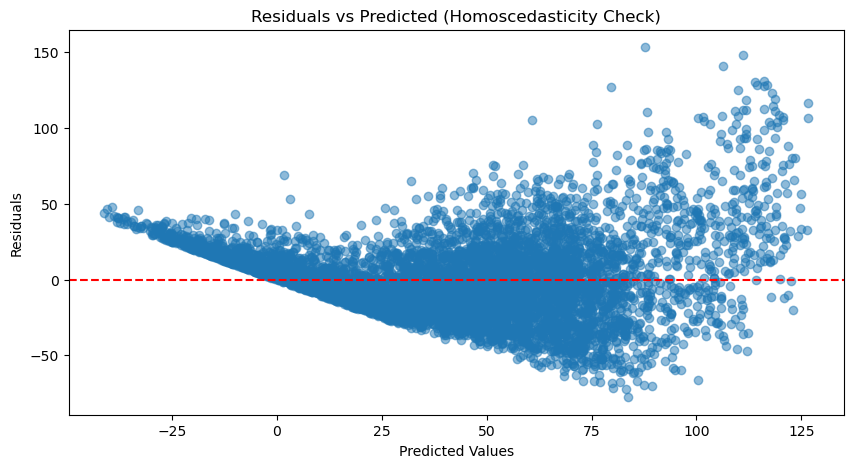

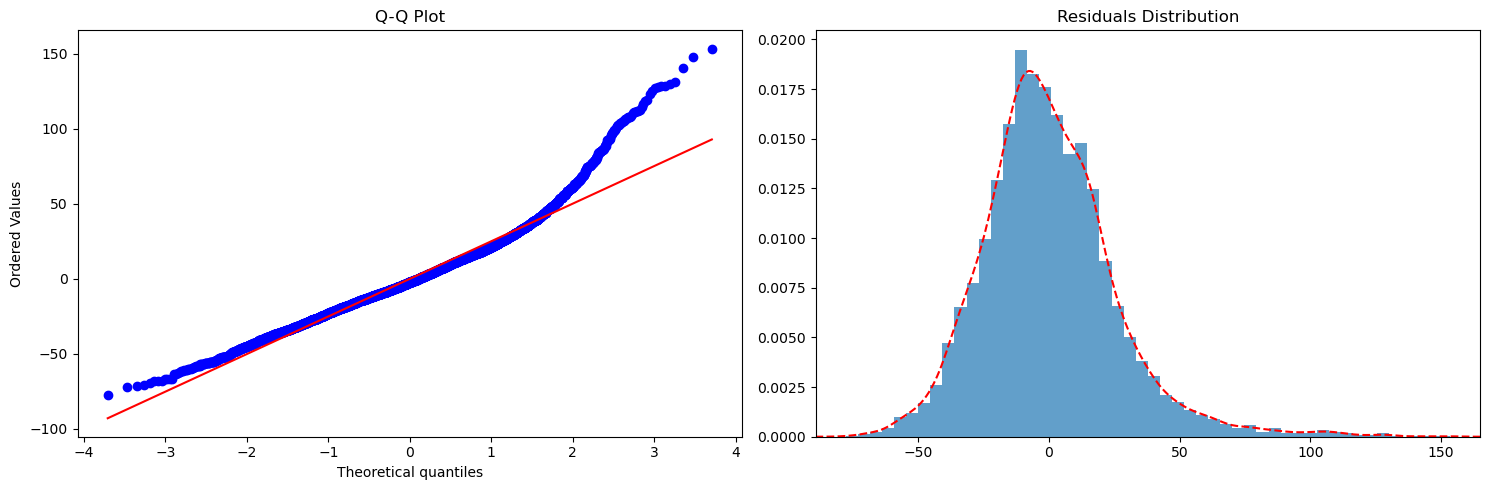

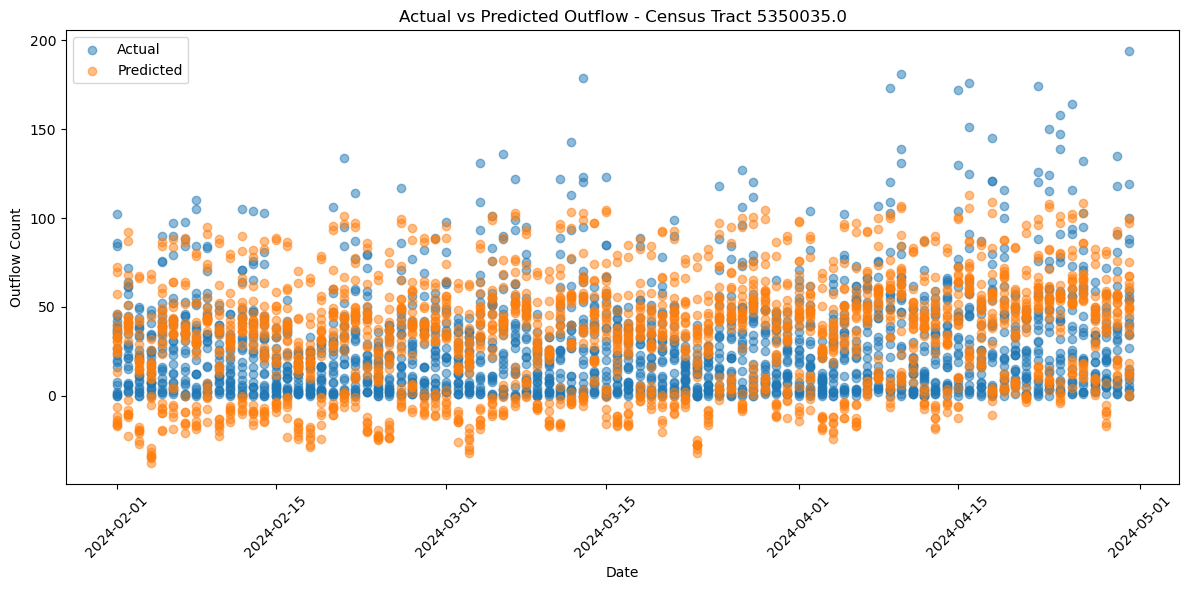

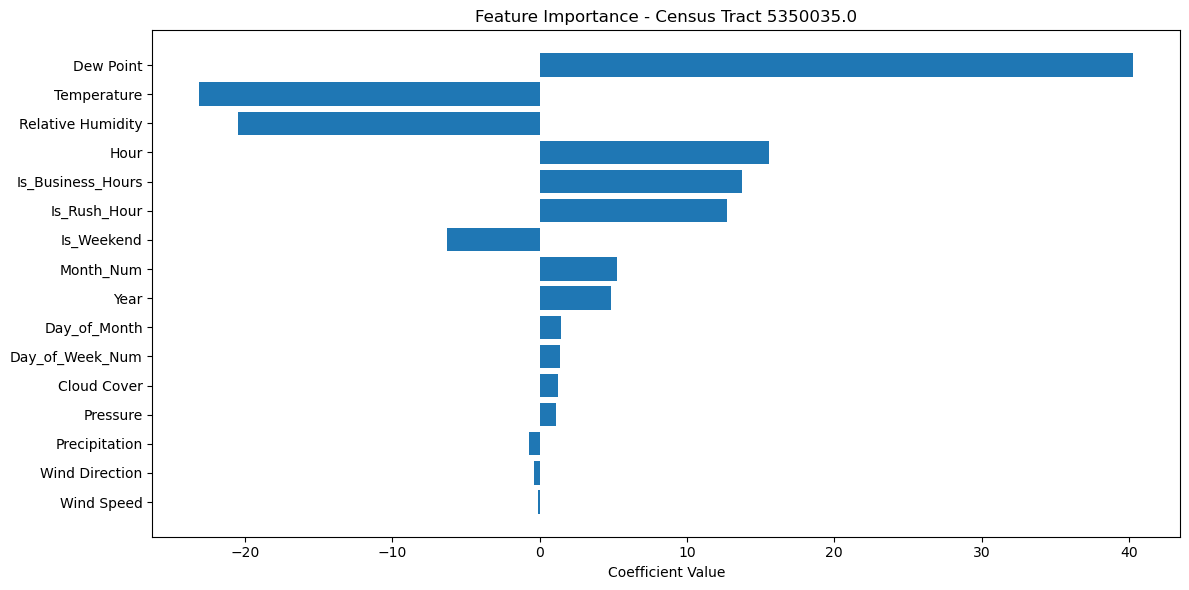


Metrics:
train_rmse: 25.5765
test_rmse: 21.0896
train_r2: 0.6159
test_r2: 0.4462
train_mape: 35468619.3801
test_mape: 37019632.5583

Top 5 most important features:
Dew Point: 40.2912
Temperature: -23.1062
Relative Humidity: -20.4800
Hour: 15.5723
Is_Business_Hours: 13.7462

Processing Census Tract: 5350014.0

Data shape for census tract 5350014.0: (8784, 22)
Train shape: (6624, 22), Test shape: (2160, 22)
Final feature shape: (6624, 16)
Number of features: 16
Final feature shape: (2160, 16)

Checking Linear Regression Assumptions:


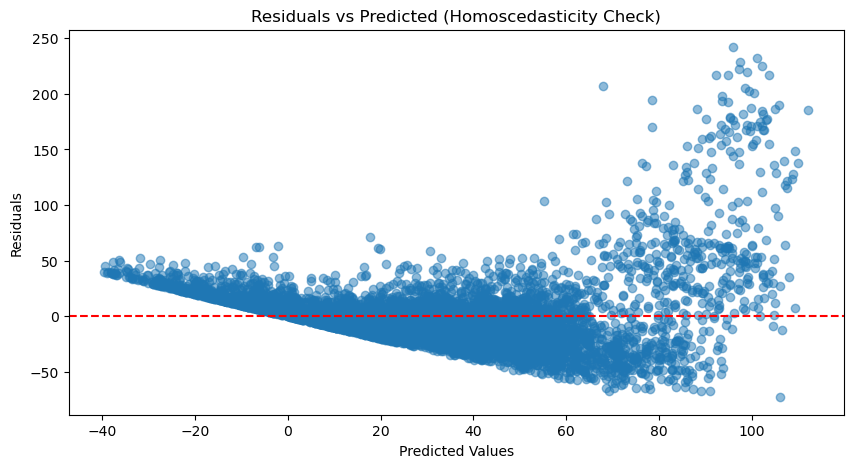

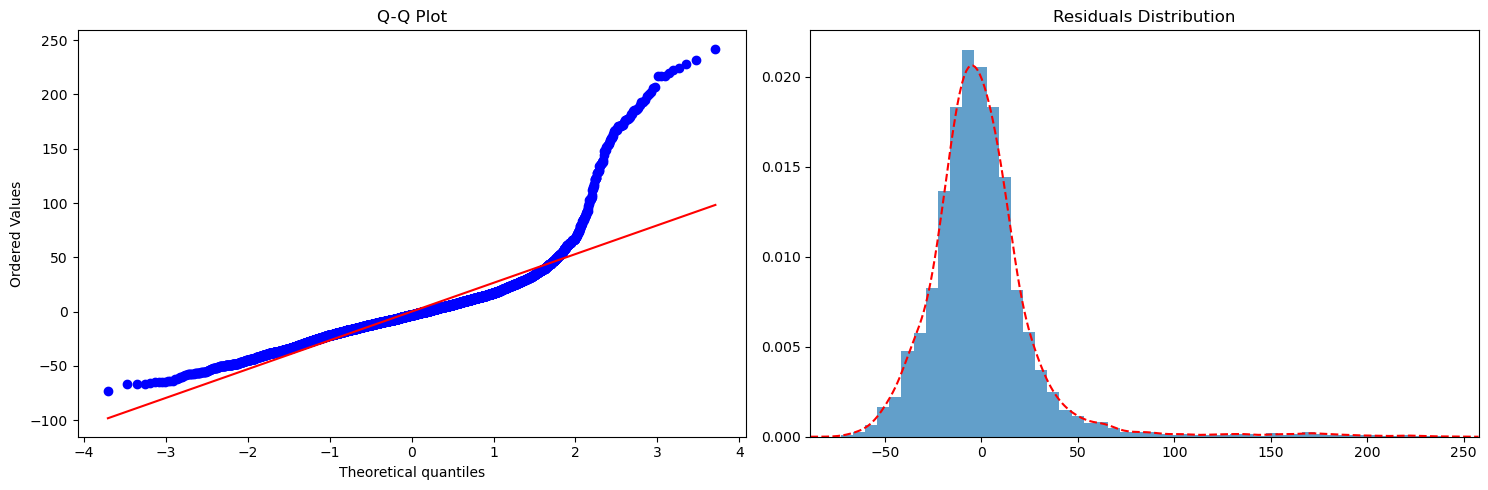

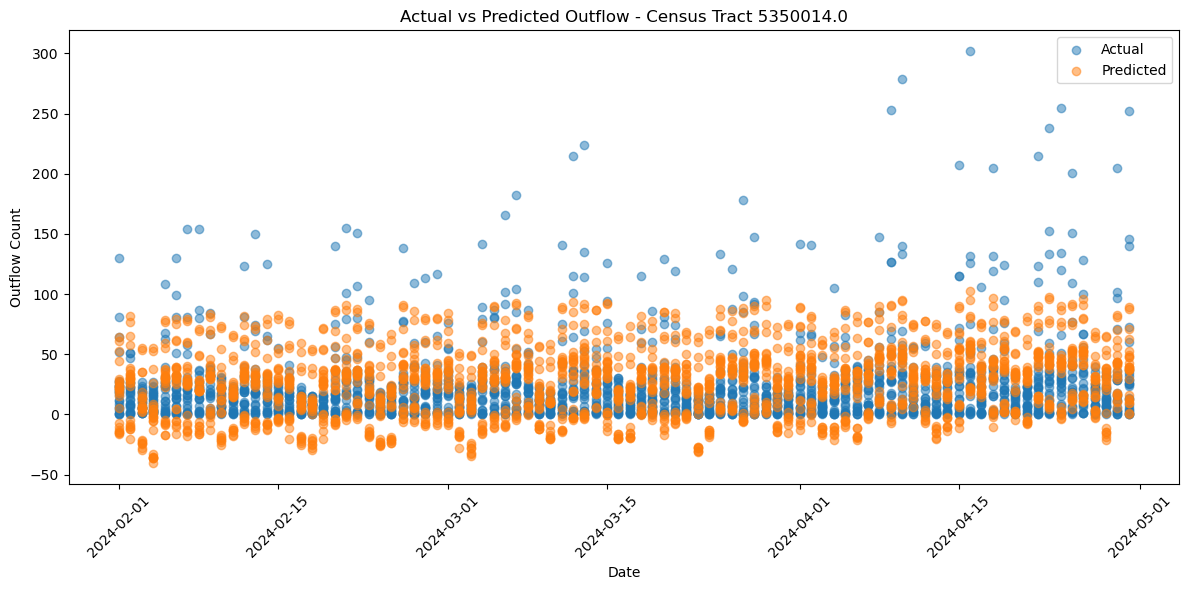

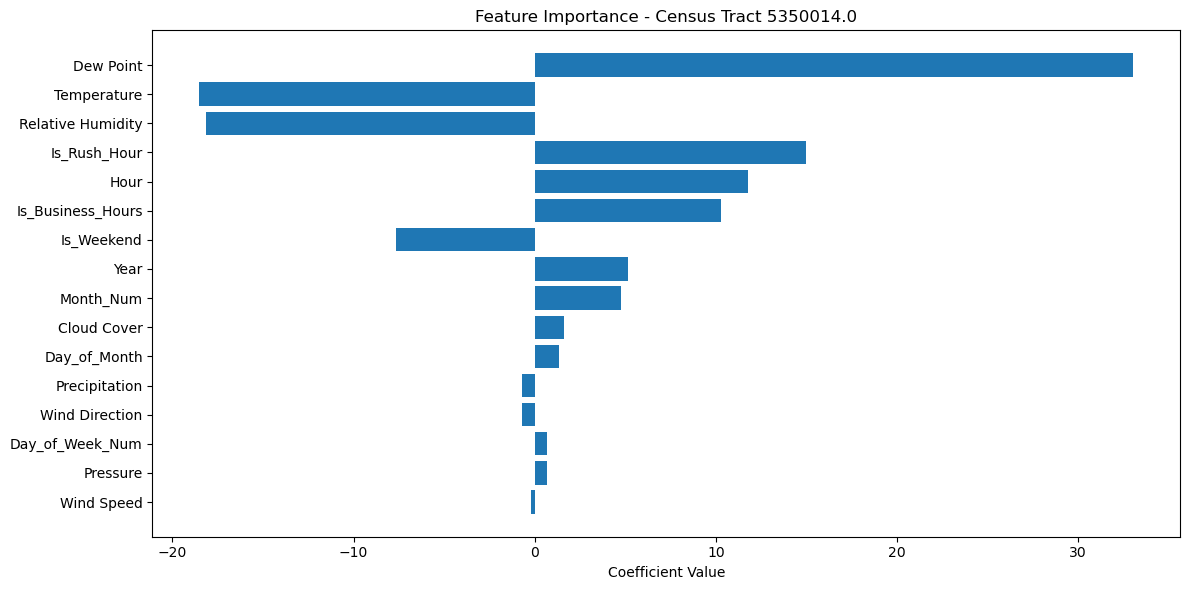


Metrics:
train_rmse: 29.6117
test_rmse: 24.5134
train_r2: 0.4850
test_r2: 0.3638
train_mape: 84816749.7750
test_mape: 95084860.9376

Top 5 most important features:
Dew Point: 33.0353
Temperature: -18.5172
Relative Humidity: -18.1430
Is_Rush_Hour: 14.9806
Hour: 11.7946


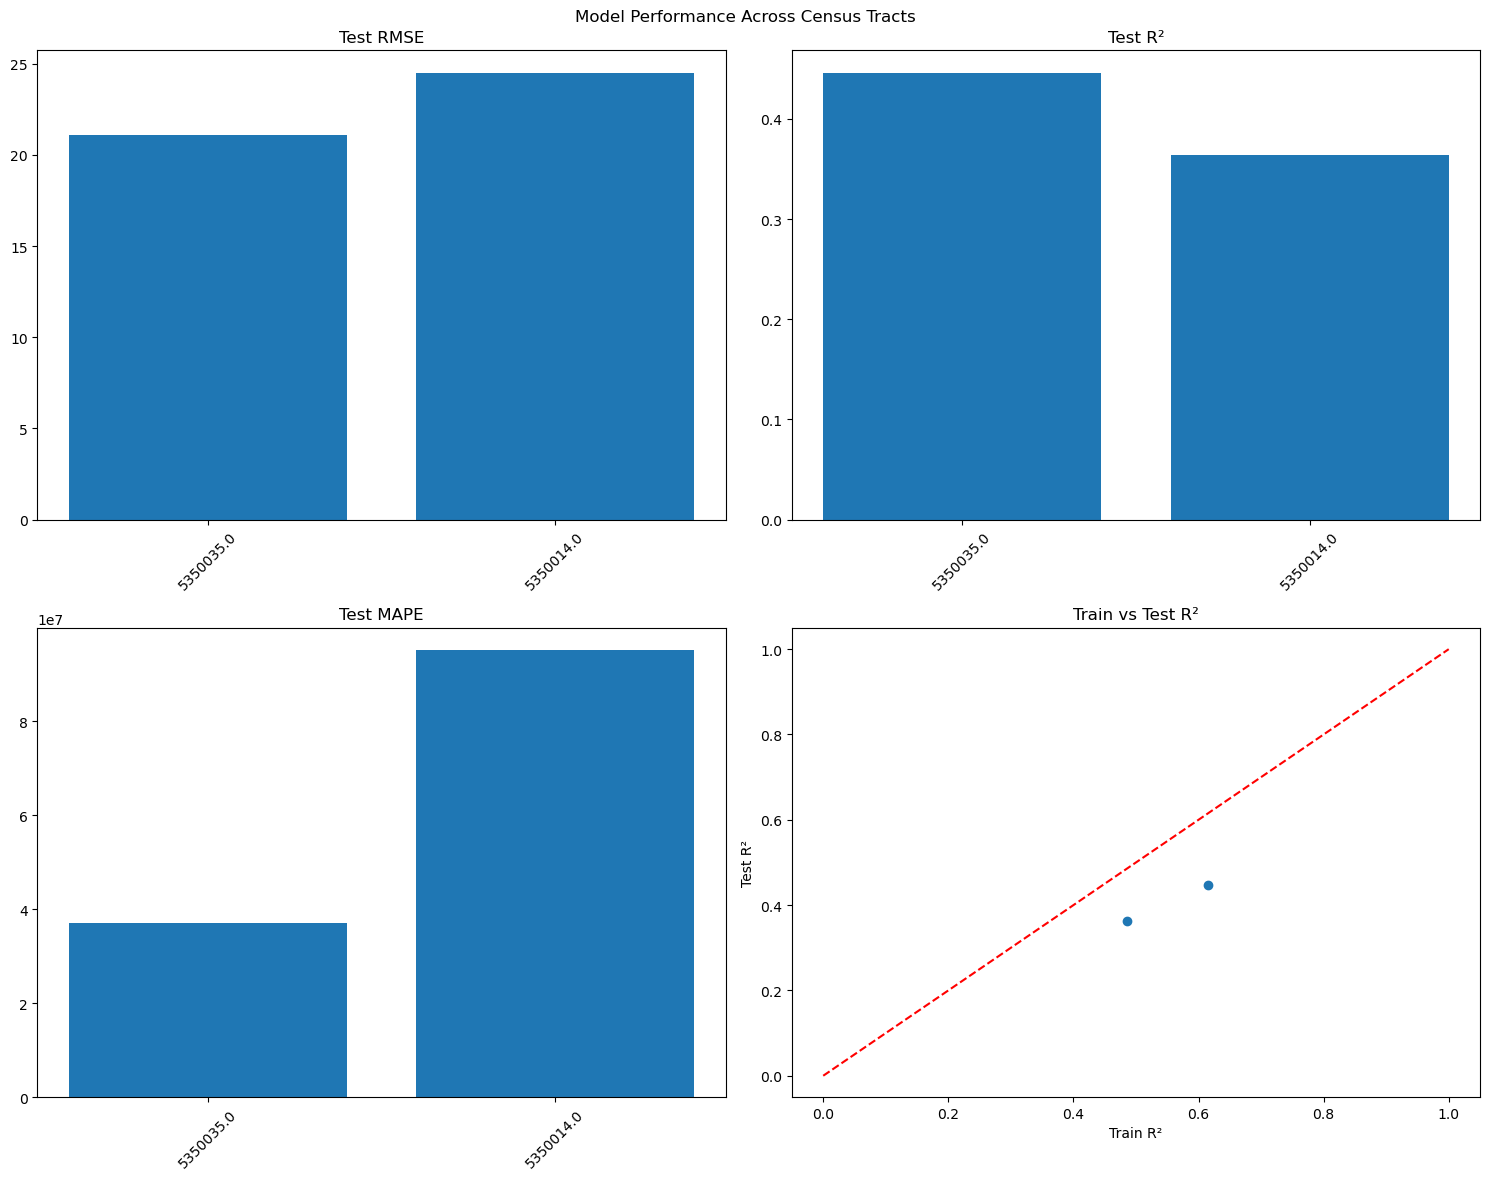

In [10]:
results = evaluate_top_census_tracts(df_aggregated, n_tracts=2)

# Model Results Analysis: Top Census Tracts

## Model Performance Analysis

We analyzed the two busiest census tracts (5350035.0 and 5350014.0) for bike-share demand forecasting. Here's a detailed breakdown of the results:

### Census Tract 5350035.0 (Busiest Area)

#### Data Split
- Total observations: 8,784 (hourly data for one year)
- Training set: 6,624 observations (until Feb 2024)
- Test set: 2,160 observations (Feb-April 2024)
- Features used: 16 (temporal and weather variables)

#### Model Performance
- Training RMSE: 25.58 trips/hour
- Test RMSE: 21.09 trips/hour
- Training R²: 0.616 (61.6% variance explained)
- Test R²: 0.446 (44.6% variance explained)

#### Key Influential Features (by coefficient magnitude)
1. Dew Point (+40.29): Strongest positive correlation
2. Temperature (-23.11): Strong negative correlation
3. Relative Humidity (-20.48): Strong negative correlation
4. Hour (+15.57): Significant time-of-day effect
5. Business Hours (+13.75): Important operational indicator

### Census Tract 5350014.0 (Second Busiest Area)

#### Data Split
- Same temporal distribution as above
- Equal number of observations and features

#### Model Performance
- Training RMSE: 29.61 trips/hour
- Test RMSE: 24.51 trips/hour
- Training R²: 0.485 (48.5% variance explained)
- Test R²: 0.364 (36.4% variance explained)

#### Key Influential Features
1. Dew Point (+33.04): Strongest positive correlation
2. Temperature (-18.52): Strong negative effect
3. Relative Humidity (-18.14): Significant negative correlation
4. Rush Hour (+14.98): Important temporal indicator
5. Hour (+11.79): Time-of-day influence

## Model Diagnostics

### Residual Analysis
1. **Homoscedasticity Check**:
   - Fan-shaped pattern in residual plots indicates heteroscedasticity
   - Variance increases with predicted values
   - Suggests model might underperform for peak demand periods

2. **Normality Assessment**:
   - Q-Q plots show deviation from normality at tails
   - Residual distributions are roughly bell-shaped but with heavy tails
   - Indicates presence of outliers and extreme values

### Prediction Performance
- Both tracts show similar patterns in actual vs predicted plots
- Model tends to underpredict high demand peaks
- More accurate predictions for average demand periods
- Consistent pattern of underprediction during extreme events

## Key Insights
1. Weather variables (particularly Dew Point and Temperature) are the strongest predictors
2. Temporal features (Hour, Business Hours, Rush Hour) show significant influence
3. Model performs better in the busier census tract (5350035.0)
4. Both models show signs of heteroscedasticity, suggesting potential for improvement
5. The linear regression approach captures general trends but struggles with extreme values

These results suggest that while the base linear model provides reasonable predictions, there's room for improvement through more sophisticated modeling approaches, particularly for handling peak demand periods.

This image shows a 2x2 grid of plots comparing model performance metrics across two census tracts (5350035.0 and 5350014.0). Let me explain each plot:

1. Test RMSE (Top Left):
- Census tract 5350035.0 shows lower RMSE (~21.0)
- Census tract 5350014.0 has higher RMSE (~24.5)
- Lower RMSE indicates better prediction accuracy in tract 5350035.0

2. Test R² (Top Right):
- Census tract 5350035.0 achieves higher R² (~0.45)
- Census tract 5350014.0 shows lower R² (~0.36)
- Higher R² suggests better fit in tract 5350035.0

3. Test MAPE (Bottom Left):
- Shows significantly different error percentages between tracts
- Tract 5350035.0: ~3.7e7%
- Tract 5350014.0: ~9.5e7%
- The extremely high MAPE values suggest issues with near-zero values in the data

4. Train vs Test R² (Bottom Right):
- Shows test R² against training R² for both tracts
- Points below the diagonal red line indicate overfitting
- Both tracts show some overfitting as test R² is lower than train R²
- Training R² values: ~0.62 and ~0.49
- Test R² values: ~0.45 and ~0.36

Overall, the model performs better on census tract 5350035.0 across all metrics, but the high MAPE values suggest that the model might need modification to better handle periods of very low demand. The presence of overfitting indicates that regularization or feature selection might improve model generalization.

# ============================================================

# Bikeshare Demand Forecasting with XGBoost

This notebook demonstrates how to build a demand forecasting model for bikeshare data using XGBoost. We'll predict hourly bike usage across different census tracts in Toronto.

## Data Preparation
The code starts with essential imports and feature preparation:

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
```

### Feature Groups
The features are organized into logical groups:

1. **Time-based Features**:
   - Year
   - Month_Num
   - Day_of_Month
   - Day_of_Week_Num
   - Hour
   - Is_Weekend
   - Is_Business_Hours
   - Is_Rush_Hour

2. **Weather Features**:
   - Temperature
   - Dew Point
   - Relative Humidity
   - Precipitation
   - Wind Direction
   - Wind Speed
   - Pressure
   - Cloud Cover

## Feature Engineering

The `prepare_features` function handles feature preparation:

```python
def prepare_features(df, fit=False):
    # Define column groups
    numeric_time_cols = ['Year', 'Month_Num', 'Day_of_Month', ...]
    weather_cols = ['Temperature', 'Dew Point', ...]
    
    # Combine all numeric columns
    numeric_cols = numeric_time_cols + weather_cols
    
    # Drop unnecessary columns and select features
    features = df.drop(['Outflow_Count', 'MA_3H', 'MA_24H', 'MA_Week', 'Date'], axis=1)
    final_features = features[numeric_cols].astype(float)
    
    return final_features
```

Key points:
- Removes moving averages and date columns
- Converts all features to float type
- Maintains consistent feature order

## Model Training

The XGBoost model is configured with the following parameters:

```python
model = XGBRegressor(
    n_estimators=100,      # Number of boosting rounds
    learning_rate=0.1,     # Step size shrinkage
    max_depth=6,           # Maximum tree depth
    min_child_weight=1,    # Minimum sum of instance weight
    subsample=0.8,         # Subsample ratio of training instances
    colsample_bytree=0.8,  # Subsample ratio of columns
    random_state=42        # For reproducibility
)
```

### Training Process
The `train_xgboost_model` function:
1. Filters data for specific census tract
2. Splits data by date (training: before 2024-02-01, testing: after)
3. Prepares features
4. Trains model with early stopping
5. Makes predictions
6. Calculates performance metrics

## Visualization

Two main visualization functions:

1. `plot_prediction_vs_actual`: Compares predicted vs actual values
```python
def plot_prediction_vs_actual(y_test, test_pred, dates, census_tract):
    plt.figure(figsize=(12, 6))
    plt.scatter(dates, y_test, label='Actual', alpha=0.5)
    plt.scatter(dates, test_pred, label='Predicted', alpha=0.5)
    ...
```

2. `plot_feature_importance`: Shows feature importance scores
```python
def plot_feature_importance(importance_dict, census_tract):
    plt.figure(figsize=(12, 6))
    importance_df = pd.DataFrame({
        'Feature': importance_dict.keys(),
        'Importance': importance_dict.values()
    })
    ...
```

## Model Evaluation

The model calculates several metrics:
1. RMSE (Root Mean Square Error)
2. R² (R-squared)
3. MAPE (Mean Absolute Percentage Error)

For both training and test sets:
```python
metrics = {
    'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
    'test_rmse': np.sqrt(mean_squared_error(y_test, test_pred)),
    'train_r2': r2_score(y_train, train_pred),
    'test_r2': r2_score(y_test, test_pred),
    'train_mape': np.mean(np.abs((y_train - train_pred) / (y_train + 1e-6))) * 100,
    'test_mape': np.mean(np.abs((y_test - test_pred) / (y_test + 1e-6))) * 100
}
```

## Running the Analysis

For a single census tract:
```python
model, metrics, importance = train_xgboost_model(df, census_tract=5350035.00)
```

For multiple census tracts:
```python
results = evaluate_top_census_tracts_xgboost(df, n_tracts=2)
```

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

def prepare_features(df, fit=False):
    """
    Prepare features for the model after initial preprocessing
    """
    # Define column groups
    numeric_time_cols = ['Year', 'Month_Num', 'Day_of_Month', 'Day_of_Week_Num', 'Hour', 
                        'Is_Weekend', 'Is_Business_Hours', 'Is_Rush_Hour']
    
    weather_cols = ['Temperature', 'Dew Point', 'Relative Humidity', 'Precipitation',
                   'Wind Direction', 'Wind Speed', 'Pressure', 'Cloud Cover']
    
    # All numeric columns
    numeric_cols = numeric_time_cols + weather_cols
    
    # Separate features
    features = df.drop(['Outflow_Count', 'MA_3H', 'MA_24H', 'MA_Week', 'Date'], axis=1)
    final_features = features[numeric_cols].astype(float)
    
    print(f"Final feature shape: {final_features.shape}")
    if fit:
        print("Number of features:", len(final_features.columns))
    
    return final_features

def plot_prediction_vs_actual(y_test, test_pred, dates, census_tract):
    """
    Plot predicted vs actual values using actual dates
    """
    plt.figure(figsize=(12, 6))
    plt.scatter(dates, y_test, label='Actual', alpha=0.5)
    plt.scatter(dates, test_pred, label='Predicted', alpha=0.5)
    plt.title(f'Actual vs Predicted Outflow - Census Tract {census_tract}')
    plt.xlabel('Date')
    plt.ylabel('Outflow Count')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_feature_importance(importance_dict, census_tract):
    """
    Plot feature importance
    """
    plt.figure(figsize=(12, 6))
    importance_df = pd.DataFrame({
        'Feature': importance_dict.keys(),
        'Importance': importance_dict.values()
    })
    importance_df = importance_df.sort_values('Importance', ascending=True)
    
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.title(f'Feature Importance - Census Tract {census_tract}')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()

def train_xgboost_model(df, census_tract, split_date='2024-02-01'):
    """
    Train and evaluate XGBoost model for a specific census tract
    """
    # Filter data for the specific census tract
    tract_data = df[df['Census_Tract'] == census_tract].copy()
    print(f"\nData shape for census tract {census_tract}: {tract_data.shape}")
    
    # Split the data using the date
    train_data = tract_data[tract_data['Date'] < split_date].copy()
    test_data = tract_data[tract_data['Date'] >= split_date].copy()
    print(f"Train shape: {train_data.shape}, Test shape: {test_data.shape}")
    
    # Prepare features
    X_train = prepare_features(train_data, fit=True)
    X_test = prepare_features(test_data, fit=False)
    
    # Get target variable
    y_train = train_data['Outflow_Count']
    y_test = test_data['Outflow_Count']
    
    # Initialize and train XGBoost model
    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='rmse',
        early_stopping_rounds=10,
        verbose=False
    )
    
    # Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, test_pred)),
        'train_r2': r2_score(y_train, train_pred),
        'test_r2': r2_score(y_test, test_pred),
        'train_mape': np.mean(np.abs((y_train - train_pred) / (y_train + 1e-6))) * 100,
        'test_mape': np.mean(np.abs((y_test - test_pred) / (y_test + 1e-6))) * 100
    }
    
    # Get feature importance
    feature_importance = dict(zip(X_train.columns, model.feature_importances_))
    
    # Plot results
    plot_prediction_vs_actual(y_test, test_pred, pd.to_datetime(test_data['Date']), census_tract)
    plot_feature_importance(feature_importance, census_tract)
    
    # Print metrics
    print("\nMetrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Print top features
    print("\nTop 5 most important features:")
    sorted_features = dict(sorted(feature_importance.items(), 
                                key=lambda x: x[1], 
                                reverse=True)[:5])
    for feature, importance in sorted_features.items():
        print(f"{feature}: {importance:.4f}")
    
    return model, metrics, feature_importance

def evaluate_top_census_tracts_xgboost(df, n_tracts=10, split_date='2024-02-01'):
    """
    Train and evaluate XGBoost models for the top n census tracts
    """
    # Get top n census tracts by total outflow
    top_tracts = (df.groupby('Census_Tract')['Outflow_Count']
                   .sum()
                   .sort_values(ascending=False)
                   .head(n_tracts)
                   .index)
    
    results = {}
    for tract in top_tracts:
        print(f"\nProcessing Census Tract: {tract}")
        model, metrics, feature_importance = train_xgboost_model(df, tract, split_date)
        results[tract] = {
            'model': model,
            'metrics': metrics,
            'feature_importance': feature_importance
        }
    
    return results

# Example usage:
# For a single census tract
# model, metrics, importance = train_xgboost_model(df, census_tract=5350035.00)

# For multiple census tracts
# results = evaluate_top_census_tracts_xgboost(df, n_tracts=2)


Processing Census Tract: 5350035.0

Data shape for census tract 5350035.0: (8784, 22)
Train shape: (6624, 22), Test shape: (2160, 22)
Final feature shape: (6624, 16)
Number of features: 16
Final feature shape: (2160, 16)


C:\Users\user\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


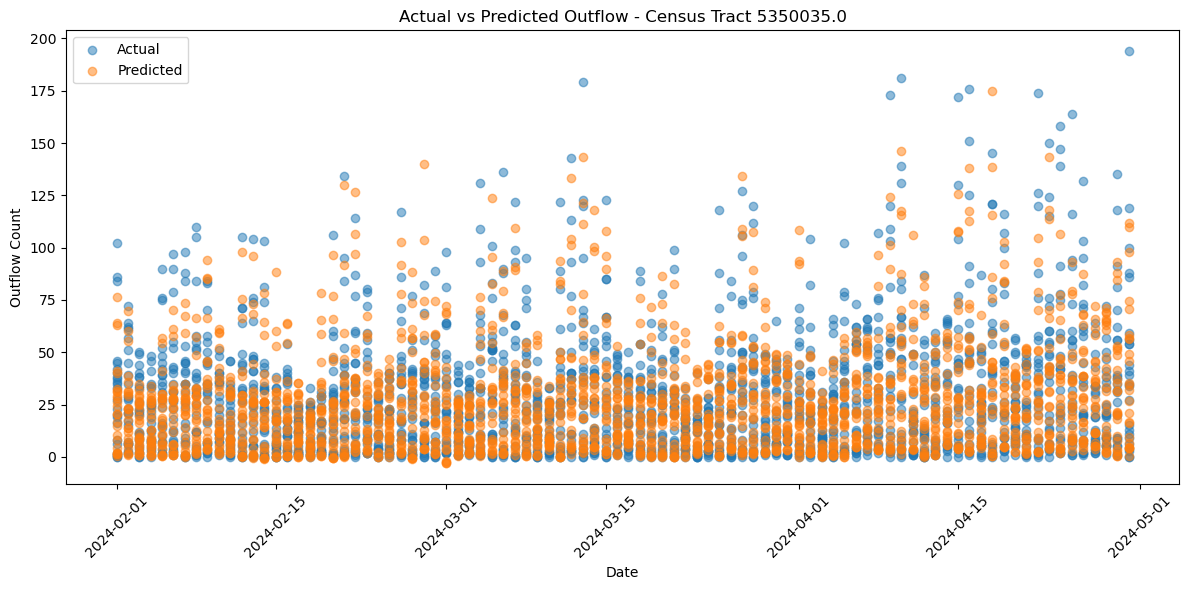

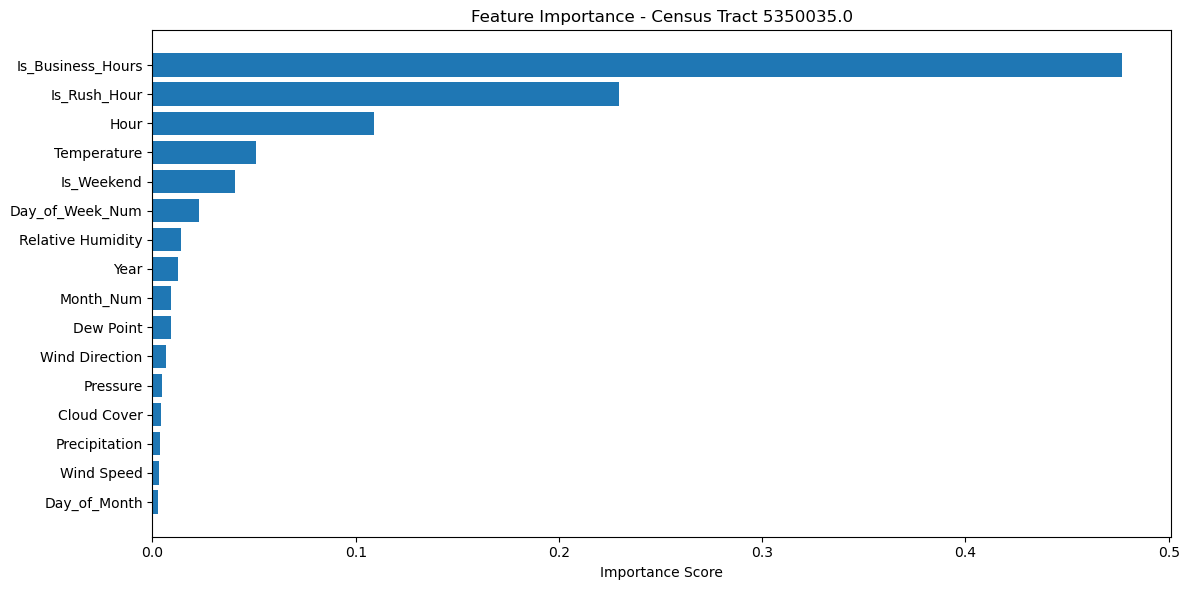


Metrics:
train_rmse: 8.9345
test_rmse: 12.5235
train_r2: 0.9531
test_r2: 0.8047
train_mape: 6028902.1742
test_mape: 8979846.1357

Top 5 most important features:
Is_Business_Hours: 0.4772
Is_Rush_Hour: 0.2294
Hour: 0.1089
Temperature: 0.0508
Is_Weekend: 0.0408

Processing Census Tract: 5350014.0

Data shape for census tract 5350014.0: (8784, 22)
Train shape: (6624, 22), Test shape: (2160, 22)
Final feature shape: (6624, 16)
Number of features: 16
Final feature shape: (2160, 16)


C:\Users\user\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


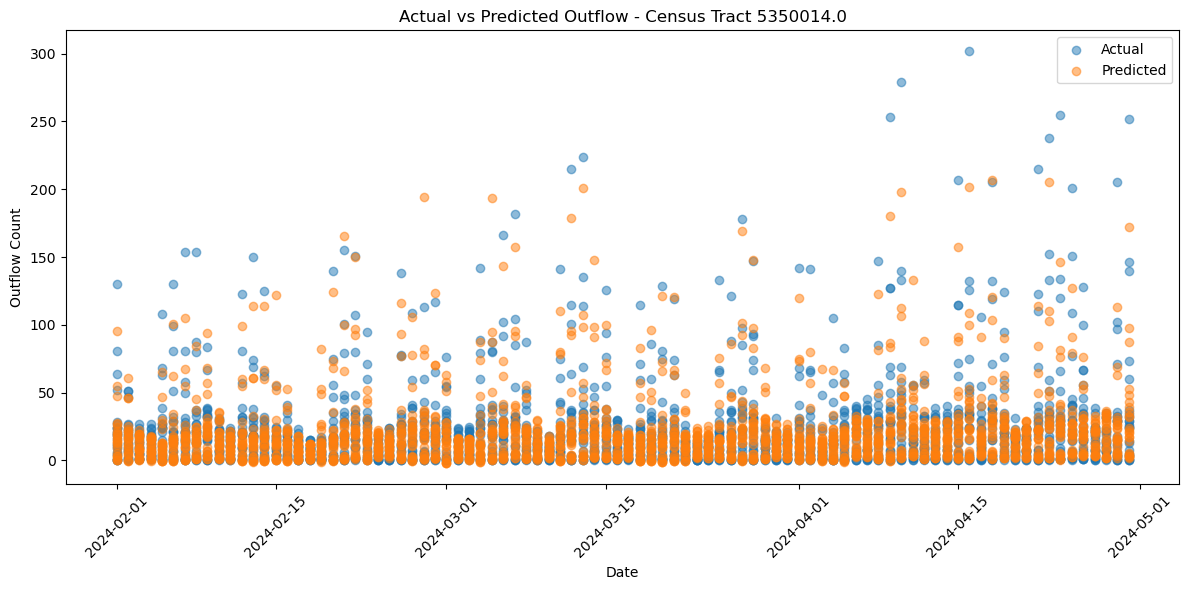

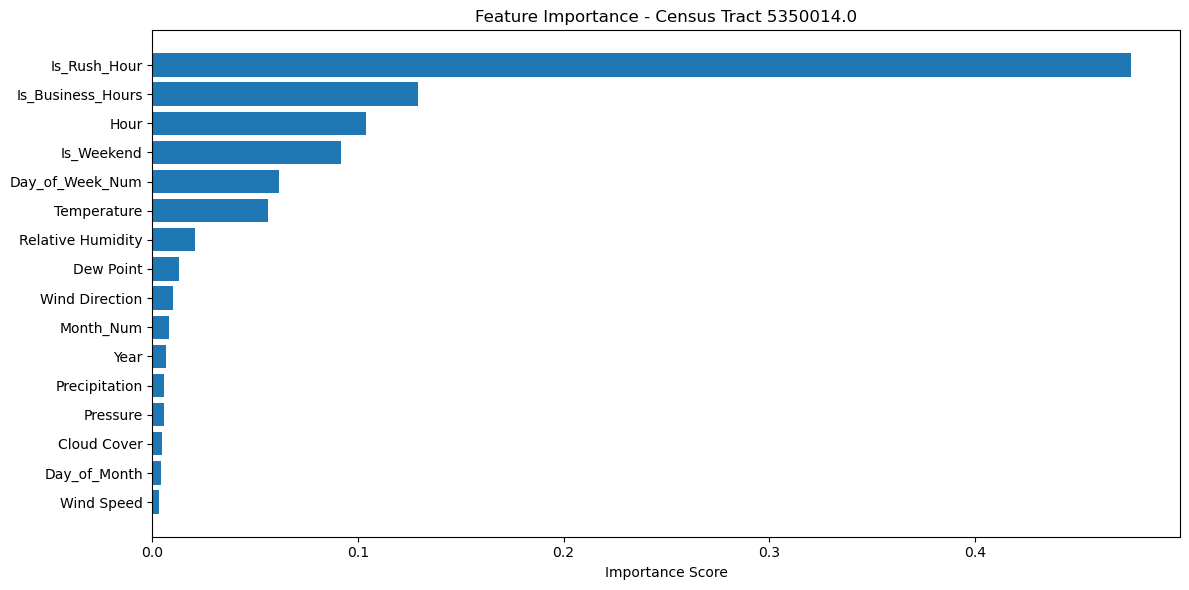


Metrics:
train_rmse: 9.3523
test_rmse: 12.6330
train_r2: 0.9486
test_r2: 0.8310
train_mape: 15382237.2587
test_mape: 18287399.9719

Top 5 most important features:
Is_Rush_Hour: 0.4760
Is_Business_Hours: 0.1291
Hour: 0.1037
Is_Weekend: 0.0918
Day_of_Week_Num: 0.0615


In [15]:
# For multiple census tracts
results = evaluate_top_census_tracts_xgboost(df, n_tracts=2)

# XGBoost Model Analysis: Top Census Tracts

## Overview
This analysis examines the performance of XGBoost models on the two busiest census tracts in Toronto's bikeshare system. The models were trained on data from May 2023 to January 2024 and tested on February-April 2024 data.

## Census Tract 5350035.0

### Data Distribution
- Total observations: 8,784 hourly records
- Training set: 6,624 observations
- Test set: 2,160 observations
- Features used: 16

### Model Performance
- Training RMSE: 8.93
- Test RMSE: 12.52
- Training R²: 0.953
- Test R²: 0.805

### Feature Importance
1. Business Hours Flag (47.72%)
2. Rush Hour Flag (22.94%)
3. Hour of Day (10.89%)
4. Temperature (5.08%)
5. Weekend Flag (4.08%)

### Visual Analysis
The time series plot shows:
- Strong daily patterns in bike usage
- Higher variance during peak hours
- Model captures overall trends but underpredicts some peak values
- Consistent performance across the test period

## Census Tract 5350014.0

### Data Distribution
- Total observations: 8,784 hourly records
- Training set: 6,624 observations
- Test set: 2,160 observations
- Features used: 16

### Model Performance
- Training RMSE: 9.35
- Test RMSE: 12.63
- Training R²: 0.949
- Test R²: 0.831

### Feature Importance
1. Rush Hour Flag (47.60%)
2. Business Hours Flag (12.91%)
3. Hour of Day (10.37%)
4. Weekend Flag (9.18%)
5. Day of Week (6.15%)

### Visual Analysis
The time series plot reveals:
- More pronounced peaks in actual usage
- Higher maximum values compared to tract 5350035.0
- Model maintains good prediction accuracy for baseline demand
- Some underestimation of extreme peaks

## Key Findings

### Model Strengths
1. Both models achieve strong R² values (>0.80) on test data
2. Consistent performance across different time periods
3. Good capture of daily and weekly patterns

### Notable Patterns
1. Time-based features dominate importance rankings
2. Weather variables have relatively lower impact
3. Business hours and rush hour flags are crucial predictors

### Areas for Improvement
1. High MAPE values suggest challenges with extreme values
2. Some underprediction during peak usage periods
3. Gap between training and test performance indicates some overfitting


# =============================================================